importing libraries

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import scipy.integrate as integrate
from matplotlib.collections import LineCollection

To specify Times New Roman font and to force that withing plotting commands

In [30]:
tnr = "Times New Roman"
plt.rcParams['font.sans-serif'] = tnr
plt.rcParams['font.family'] = tnr
params ={'mathtext.default':'regular'}          
plt.rcParams.update(params)

setting user defined parameters

In [31]:
R_star = 1.e7 # km
V_inf = 2250. # km/s
beta = 1.0001
M_lossrate = 2*(10**(30))*1.e-6 # kg/s
R_shock = 1.5*R_star
T_star = 2.
u_o = R_star/R_shock
maxratio = 8. # max ratio of r/R_star on the grid, so that the grid plotted are scaled by R_star
q = 0.

setting up the grid

In [32]:
interval = 200
x = np.linspace(-maxratio, maxratio, interval)
y = np.linspace(-maxratio, maxratio, interval)   
X, Y = np.meshgrid(x, y)

Function that computes radial velocity over terminal velocity on the grid

In [33]:
def f(x, y):
    r = np.sqrt(x**2+y**2)
    v = (1-1/r)**beta
    return -(x/r)*v

Function that computes the intensity proportional to density squared on the grid

In [34]:
def g(x, y):
    r = np.sqrt(x**2+y**2)
    v = (V_inf/R_star)*(1-1/r)**beta
    return -(np.log10((M_lossrate/(4*np.pi*(r**2)*v))**2))

Funtion that computes the optical depth

In [35]:
op = []
for i in (y):
    arr = []
    if i < -1 or i >1:
        for j in (x):
            arr.append(T_star*(integrate.quad(lambda a: 1/((a**2+i**2)*((1-1/np.sqrt(a**2+i**2))**beta)), -np.inf, j)[0]))
    if -1 <= i and i <= 1:
        for j in (x):
            if -np.sqrt(1-i**2) <= j:
                arr.append(np.inf)
            else:
                arr.append(T_star*(integrate.quad(lambda a: 1/((a**2+i**2)*((1-1/np.sqrt(a**2+i**2))**beta)), -np.inf, j)[0]))  
    op.append(arr)

luminosity over wavelength line profile

In [36]:
wavelength = np.linspace(-0.99999, 0.99999, interval)
luminosity = []
for i in (wavelength):
    u_x = 1-np.absolute(i)**(1/beta)
    u_crit = 1/np.sqrt(1+1/(u_x)**2)
    if i < 0:
        if u_o < u_x:
            u_boundary = u_o
        else:
            u_boundary = u_x
    if i >= 0:
        if u_o < u_crit:
            u_boundary = u_o
        else:
            u_boundary = u_crit
    lum = integrate.quad(lambda u: ((1/u)**(-q)/((1-u)**(3*beta))*np.exp(-T_star*i*integrate.quad(lambda u: 1/((1-u)**(2*beta)), 0, u)[0])), 0, u_boundary)[0]
    luminosity.append(lum)
luminosity = luminosity/np.max(luminosity)

Actually making the plot

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


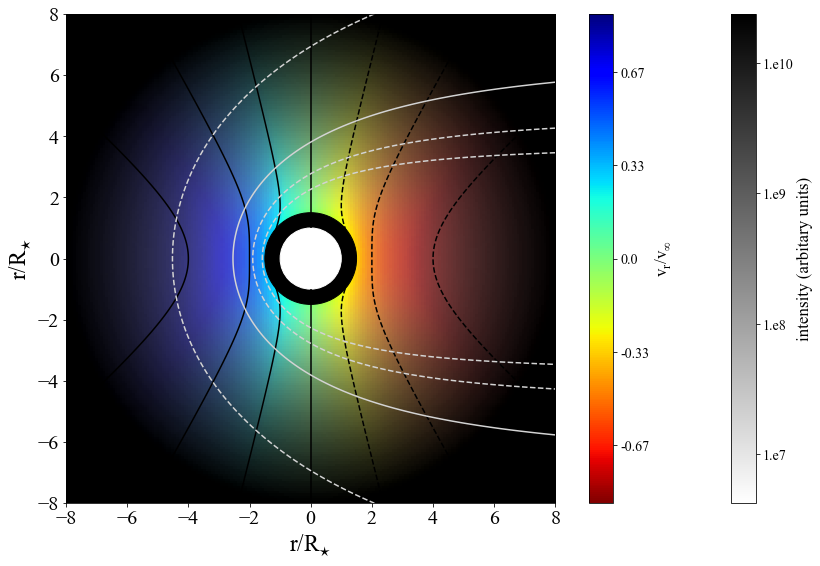

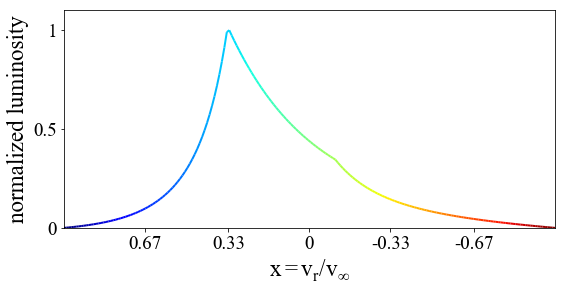

In [37]:
# setting up figure size and range

plt.figure(figsize = (15, 9))

plt.xlim(-maxratio, maxratio)
plt.ylim(-maxratio, maxratio)


# labeling axis and ticks

plt.xlabel(r'$r/R_{\star}$', fontsize = 23)
plt.ylabel(r'$r/R_{\star}$', fontsize = 23)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)


# drawing star and the stellar wind boundary

shock = plt.Circle((0, 0), R_shock/R_star, color='black')
plt.gca().add_patch(shock)

star = plt.Circle((0,0), 1, color = 'white')
plt.gca().add_patch(star)


# plotting redshift and contours

color = f(X, Y)

redshift_contour = plt.contour(X, Y, color, 7, colors = 'black')
redshift = plt.imshow(color, extent = [-maxratio, maxratio, -maxratio, maxratio], origin = 'lower', cmap = plt.cm.jet_r, alpha = 1)
#plt.clabel(plt.contour(X, Y, color))


# plotting log10(density^2)

alphas = Normalize(g(R_shock/R_star, 0), g(maxratio, 0), clip = True)(g(X, Y)) # setting up transparency as a function of -log10(density^2)
brightness = Normalize(g(R_shock/R_star, 0), g(maxratio, 0), clip = True)(g(X, Y))
brightness = plt.cm.gray_r(brightness)
brightness[..., -1] = alphas

intensity = plt.imshow(brightness, extent = [-maxratio, maxratio, -maxratio, maxratio], origin = 'lower', cmap = plt.cm.gray_r)
#plt.clabel(plt.contour(X, Y, g(X, Y)))


# plotting optical depth contours
depth = plt.contour(x, y, op, levels = [0.5, 1.5, 2], colors = 'lightgray', linestyles='dashed')
depth = plt.contour(x, y, op, levels = [1], colors = 'lightgray')

# drawing intensity color bar

intensity_ticks = np.linspace(5/50, 45/50, 4) # 5/50 and 45/50 are tested values where 7 and 10 are, if 6.65 = g(R_shock/R_star, 0) to 10.4 = g(maxratio, 0) are normalized from 0 to 1
corrected_intensity_ticks = '1.e7', '1.e8', '1.e9', '1.e10'

intensity_cb = plt.colorbar(intensity, ticks = intensity_ticks)
intensity_cb.ax.set_yticklabels(corrected_intensity_ticks, fontsize = 14)
intensity_cb.ax.set_ylabel(r'intensity (arbitary units)', fontsize = 17)


# drawing redshift color bar

redshift_shock = f(R_shock/R_star, 0)
redshift_ticks = 2*redshift_shock, redshift_shock, 0, -redshift_shock, -2*redshift_shock

redshift_cb = plt.colorbar(redshift, ticks = redshift_ticks)
redshift_cb.ax.set_yticklabels(np.round(redshift_ticks, decimals = 2), fontsize = 14)
redshift_cb.ax.set_ylabel(r'$v_r/v_{\infty}$', fontsize = 17)

plt.savefig('wind_contour_plot.png')

# plotting line profile

points = np.array([wavelength, luminosity]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots(figsize = (8.8, 4))

lc = LineCollection(segments, cmap = plt.cm.jet, norm = plt.Normalize(wavelength.min(), wavelength.max(), clip = True))
lc.set_array(wavelength)
lc.set_linewidth(2)
ax.add_collection(lc)

ax.set_ylim(0.00, np.max(luminosity)*1.1)
ax.set_xlim(-1, 1)

ax.set_xlabel(r'$x = v_r/v_{\infty}$', fontsize=23)
ax.set_ylabel('normalized luminosity', fontsize=23)
ax.set_xticks([-0.67, -0.33, 0, 0.33, 0.67])
ax.set_xticklabels([0.67, 0.33, 0, -0.33, -0.67], fontsize = 19)
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels([0, 0.5, 1], fontsize = 19)

plt.savefig('line_profile')
plt.show()